## Demo Pendulum using Deep Deterministic Policy Gradient (DDPG) RL algorithm
 - Demonstrates the classic inverted pendulum swingup problem that is based on the classic problem in control theory.
 - The system consists of a pendulum attached at one end to a fixed point, and the other end being free. The pendulum starts in a random position and the goal is to apply torque on the free end to swing it into an upright position, with its center of gravity right above the fixed point.
 - The problem/environment consist of 3 state/observation variables:
   - x Position of the pendulum => x = cos(theta) [-1 (min), 1 (max)]
   - y Position of the pendulum => y = sin(theta) [-1 (min), 1 (max)]
   - a Angular Velocity of the pendulum => [-8 (min), 8 (max)]
 - The action space of the problem/environment:
   - Torque of the pendulum [-2 (min), 2 (min)]
   - The action is in continuous space
 - Further details of the problem enviroment settings can found in this [Gymnasium documentation](https://gymnasium.farama.org/environments/classic_control/pendulum/)
 - The RL DDPG algorithm is based on the [Machin](https://machin.readthedocs.io/en/latest/about.html) RL library
 - Further details of the Machin RL framework can be found in this [repo](https://github.com/iffiX/machin/tree/master)


#### Installs

In [13]:
# !pip install gymnasium[classic_control] numpy matplotlib machin pyvirtualdisplay

#### Specify imports

In [9]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display
from machin.frame.algorithms import DDPGPer
from machin.utils.logging import default_logger as logger
from machin.model.nets import static_module_wrapper
import torch as t
import torch.nn as nn
from typing import Tuple, List, Any
import os, sys

sys.path.insert(1, "../")
import src.main.configs.global_configs as configs
from src.main.utility.chart_results import ChartResults

#### Define global configurations

In [2]:
# Pendulum RL environment configurations
PENDULUM_ENV = gym.make("Pendulum-v1", render_mode="rgb_array")
STATE_DIM = 3
ACTION_DIM = 1
ACTION_RANGE = 2
MAX_EPISODES = 1000
MAX_STEPS = 200
NOISE_PARAMETER = (0, 0.2)
NOISE_MODE = "normal"
SOLVED_REWARS = -150
SOLVED_REPEAT = 5
EPISODE_UPDATE_FREQUENCY = 200

# Rendering configs
DPI = 72
INTERVAL = 100 # ms

#### Utility class of helper functions

In [3]:
class Helpers:
  """
  Utility class of helper functions
  """
  @staticmethod
  def animateEnvironment(images: List[Any]):
    """
    Animates the environment
    :param images: Images
    """
    plt.figure(
        figsize=(images[0].shape[1]/DPI,images[0].shape[0]/DPI),
        dpi=DPI
        )
    patch = plt.imshow(images[0])
    plt.axis=('off')
    animate = lambda i: patch.set_data(images[i])
    ani = FuncAnimation(
        plt.gcf(),
        animate,
        frames=len(images),
        interval=INTERVAL)
    display.display(display.HTML(ani.to_jshtml()))
    plt.close()

#### Solution steps:
 - Step 1: Define Actor network of the DDPG RL algorithm
 - Step 2: Define Critic network of the DDPG RL algorithm
 - Step 3: Implement the DDPG RL training loop
 - Step 4: Implement the RL traievaluation (with animation) policy

##### STEP 1: Define Actor network of the DDPG RL algorithm[link text](https://)

In [4]:
class Actor(nn.Module):
  """
  Actor network of the DDPG RL algorithm
  """
  def __init__(self, state_dim, action_dim, action_range):
      super().__init__()

      self.fc1 = nn.Linear(state_dim, 16)
      self.fc2 = nn.Linear(16, 16)
      self.fc3 = nn.Linear(16, action_dim)
      self.action_range = action_range

  def forward(self, state):
      a = t.relu(self.fc1(state))
      a = t.relu(self.fc2(a))
      a = t.tanh(self.fc3(a)) * self.action_range
      return a

##### STEP 2: Define Critic network of the DDPG RL algorithm

In [5]:
class Critic(nn.Module):
  """
  Critic network of the DDPG RL algorithm
  """
  def __init__(self, state_dim, action_dim):
      super().__init__()

      self.fc1 = nn.Linear(state_dim + action_dim, 16)
      self.fc2 = nn.Linear(16, 16)
      self.fc3 = nn.Linear(16, 1)

  def forward(self, state, action):
      state_action = t.cat([state, action], 1)
      q = t.relu(self.fc1(state_action))
      q = t.relu(self.fc2(q))
      q = self.fc3(q)
      return q


##### STEP 3: Implement the DDPG RL training loop

In [6]:
class DDPGAgent:
  """
  DDPG agent training loop
  """
  def __init__(
      self,
      env=PENDULUM_ENV,
      n_episodes=MAX_EPISODES,
      max_steps=MAX_STEPS,
      noise_parameter=NOISE_PARAMETER,
      noise_mode=NOISE_MODE,
      state_dim=STATE_DIM,
      action_dim=ACTION_DIM,
      action_range=ACTION_RANGE
  ):
    """
    Initializes the DQN agent training loop
    :param env: Environment
    :param n_episodes: Number of episodes
    :param max_steps: Maximum number of steps
    :param noise_parameter: Noise parameter
    :param noise_mode: Noise
    """
    self.env = env
    self.n_episodes = n_episodes
    self.max_steps = max_steps
    self.noise_parameter = noise_parameter
    self.noise_mode = noise_mode
    self.state_dim = state_dim
    self.action_dim = action_dim
    self.action_range = action_range
    self.device = t.device("cuda" if t.cuda.is_available() else "cpu")

    actor = Actor(self.state_dim, self.action_dim, self.action_range)
    self.actor = static_module_wrapper(actor, "cpu", "cpu")
    actor_t = Actor(self.state_dim, self.action_dim, self.action_range)
    self.actor_t = static_module_wrapper(actor_t, "cpu", "cpu")

    critic = Critic(self.state_dim, self.action_dim)
    self.critic = static_module_wrapper(critic, "cpu", "cpu")
    critic_t = Critic(self.state_dim, self.action_dim)
    self.critic_t = static_module_wrapper(critic_t, "cpu", "cpu")

    self.ddpg_per = DDPGPer(
        self.actor,
        self.actor_t,
        self.critic,
        self.critic_t,
        t.optim.Adam,
        nn.MSELoss(reduction="sum")
    )

    self.step, self.reward_fulfilled = 0, 0
    self.smoothed_total_reward = 0

  def train(self):
    """
    Trains the DQN agent
    """
    all_rewards = []

    for episode in range(1, self.n_episodes+1):
      # print(f"Episode: {self.episode}")
      total_reward = 0
      terminal = False
      self.step = 0
      state_0, _ = self.env.reset()
      state = t.tensor(state_0, dtype=t.float32).view(1, self.state_dim)
      tmp_observations = []

      while not terminal and self.step <= self.max_steps:
        self.step += 1
        with t.no_grad():
            old_state = state
            # agent model inference
            action = self.ddpg_per.act_with_noise(
                {"state": old_state},
                noise_param=self.noise_parameter,
                mode=self.noise_mode
            )
            state, reward, terminal, _, _ = self.env.step(action.numpy())
            # print(f"terminal: {terminal}")
            state = t.tensor(state, dtype=t.float32).view(1, self.state_dim)
            total_reward += reward[0]

            tmp_observations.append(
                {
                    "state": {"state": old_state},
                    "action": {"action": action},
                    "next_state": {"state": state},
                    "reward": reward[0],
                    "terminal": terminal or self.step == self.max_steps,
                }
              )

      self.ddpg_per.store_episode(tmp_observations)
      # update, update more if episode is longer, else less
      if episode > 100:
          for _ in range(self.step):
              self.ddpg_per.update()

      all_rewards.append(total_reward)

      if episode % EPISODE_UPDATE_FREQUENCY == 0:
            print(f"Episode: {episode}, Avg Reward: {np.mean(all_rewards[-EPISODE_UPDATE_FREQUENCY:]):.3f}")

    return self.ddpg_per, all_rewards



In [7]:
env = PENDULUM_ENV
agent = DDPGAgent(env)
ddpg_net, rewards = agent.train()

[2025-06-01 10:39:06,440] <WARNING>:default_logger:The reduction property of criterion is not 'none', automatically corrected.


Episode: 200, Avg Reward: -906.879
Episode: 400, Avg Reward: -139.738
Episode: 600, Avg Reward: -177.634
Episode: 800, Avg Reward: -247.307
Episode: 1000, Avg Reward: -143.709


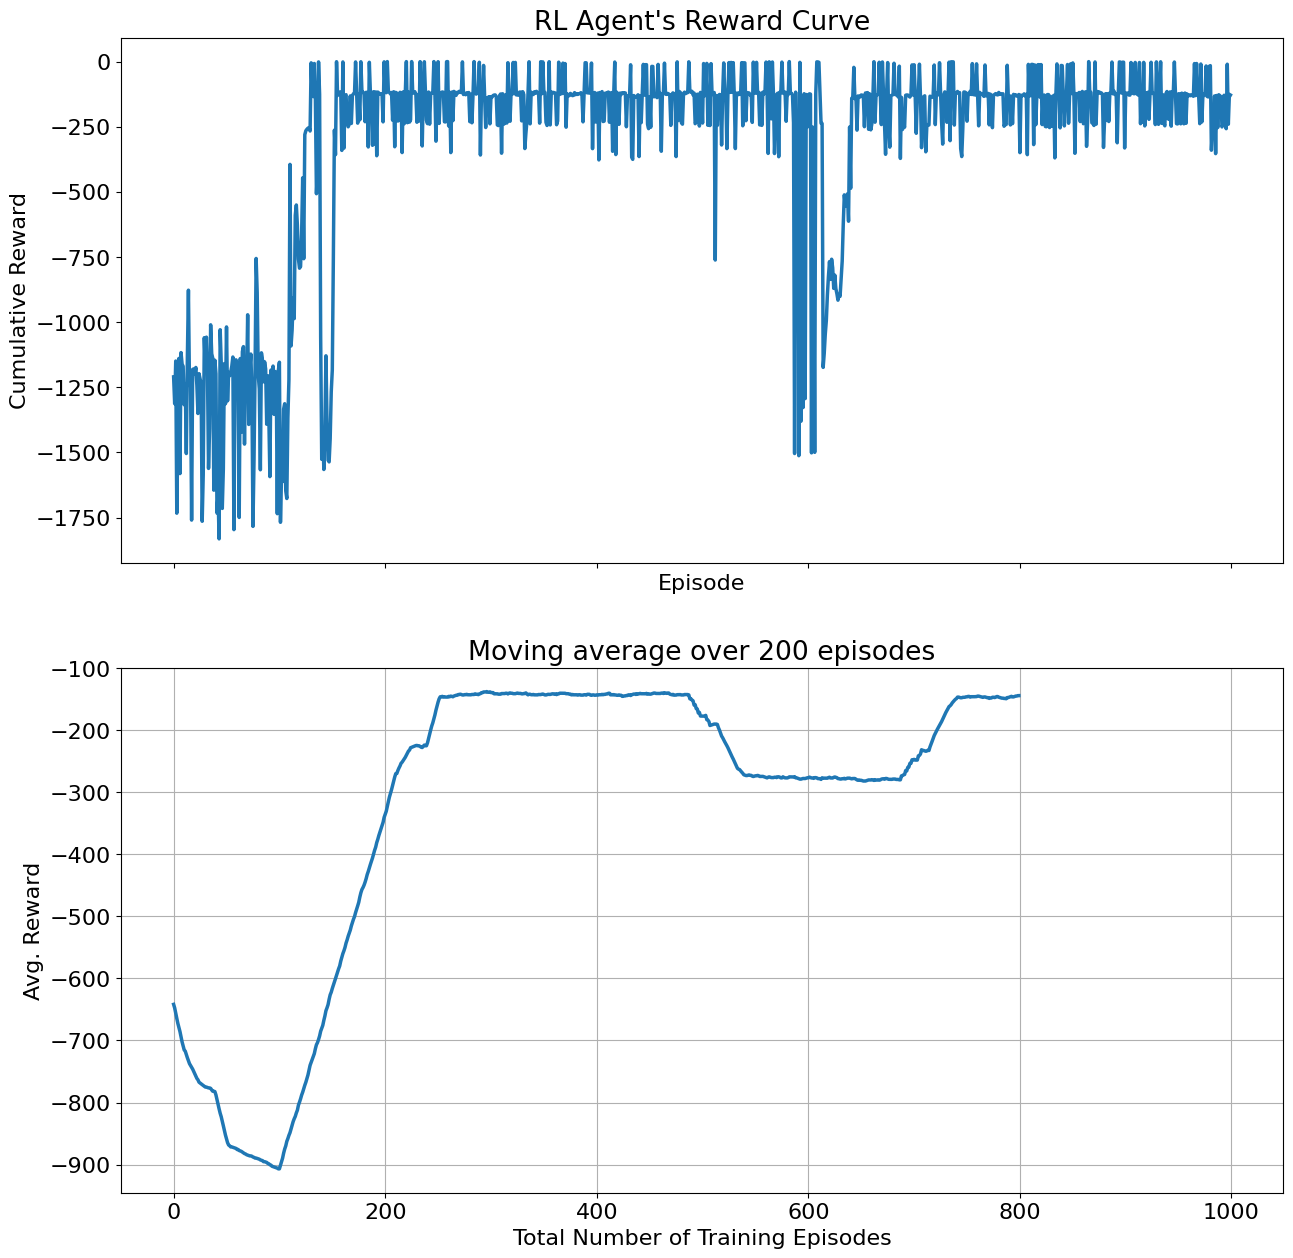

In [10]:
print("\n\n")
ChartResults.plotRewardCurve(rewards, window_size=200)

#### Step 4: Implement the RL traievaluation (with animation) policy

In [14]:
class EvaluateDDPGAgent:
  """
  Evaluate the DDPG RL agent using animation of the simulation runs
  """
  def __init__(
      self, 
      agent, 
      env, 
      n_episodes=10, 
      max_steps=100,
      render_mode=configs.RENDER_MODE
  ):
    """
    Constructor
    :param agent: RL agent
    :param env: Environment
    :param n_episodes: Number of episodes to run
    :param max_steps: Maximum number of steps
    :param render_mode: Render mode
    """
    self.agent = agent
    self.env = env
    self.n_episodes = n_episodes
    self.max_steps = max_steps
    self.render_mode = render_mode
    if self.render_mode == "human":
        self.display = None
    else:
        self.device = t.device("cuda" if t.cuda.is_available() else "cpu")
        self.display = Display(visible=0, size=(400, 400))      
        self.display.start()
    self.trajectories = []
    self.images = []

  def _evaluate(self):
    """
    Evaluate the agent
    """
    for ep in range(self.n_episodes):
      total_reward = 0
      terminal = False
      self.step = 0
      state_0, _ = self.env.reset()
      state = t.tensor(state_0, dtype=t.float32).view(1, self.agent.state_dim)
      tmp_observations = []

      #while not done:
      for _ in range(self.max_steps):
        with t.no_grad():
            old_state = state
            # agent model inference
            action = self.agent.ddpg_per.act_with_noise(
                {"state": old_state},
                noise_param=self.agent.noise_parameter,
                mode=self.agent.noise_mode
            )
            state, reward, terminal, _, _ = self.env.step(action.numpy())
            state = t.tensor(state, dtype=t.float32).view(1, self.agent.state_dim)
            total_reward += reward[0]

            tmp_observations.append(
                {
                    "state": {"state": old_state},
                    "action": {"action": action},
                    "next_state": {"state": state},
                    "reward": reward[0],
                    "terminal": terminal or self.step == self.max_steps,
                }
              )
            
        if self.render_mode == "human":
            self.env.render()
        else:
            self.images.append(self.env.render())
        

        if terminal:
              break

      # self.env.close()

  def run(self):
    """
    Run the RL evaluation with animation
    """
    self._evaluate()
    if self.render_mode != "human":
        Helpers.animateEnvironment(self.images)

In [15]:
env = gym.make("Pendulum-v1", render_mode="human")
evaluate = EvaluateDDPGAgent(agent, env, render_mode="human")
evaluate.run()

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [22]:
df = pd.read_csv("C:/Users/adeid/Downloads/monitor.csv", index_col=None, skiprows=[0])
df.head()

,r,l,t
0,-1787.173705,200,2.189822
1,-1733.258062,200,3.048094
2,-1124.656961,200,3.880016
3,-1499.952635,200,4.720226
4,-1736.890771,200,5.608283


Text(0.5, 1.0, 'Moving average over 200 episodes')

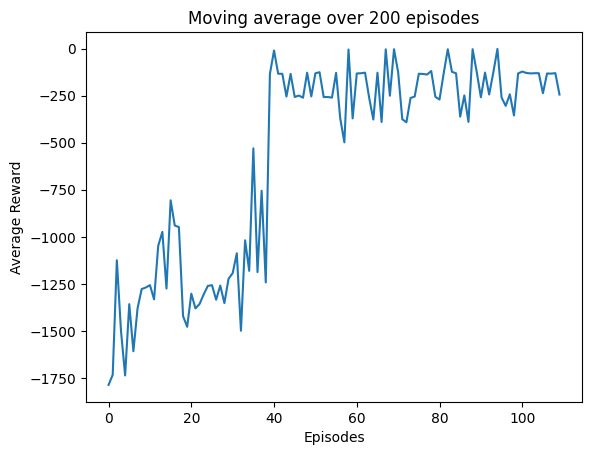

In [23]:
data = np.cumsum(-df.r.values)
plt.plot(df.r.values)
plt.xlabel("Episodes")
plt.ylabel("Average Reward")
plt.title("Moving average over 200 episodes")